In [1]:
# nobody knows anything
#                  -Kai
#
# github.com/kaibrooks

In [37]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
import io
import os
import matplotlib.pyplot as plt # fancy plots
from datetime import datetime # so we know how much time we've wasted

In [21]:
# doin thangs
epochs=10 #60
epochOutput = False
diversity = [0.2, 0.5, 1.0, 1.2]

In [22]:
## get text file

#path = get_file( # use this for http request
#    'afile.txt',
#    origin='http://omega.lul/afile.txt')

path = 'data/drseuss.txt'

with open(path, encoding='utf-8', errors='ignore') as f: # errors=ignore strips non utf-8 chars
    text = f.read().lower()
print('corpus length:', len(text))

corpus length: 30504


In [23]:
chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

print('Vectorizing...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
print('Done')

total chars: 39
nb sequences: 10155
Vectorizing...
Done


In [24]:
# model
print('Building model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars), activation='softmax'))
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
print('Done')

Building model...
Done


In [25]:
# train me

now = datetime.now()
print("Starting training at", now.strftime("%d-%b-%Y %H:%M:%S")) # lets see how long this takes

def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def on_epoch_end(epoch, _):
    if epochOutput:
        # print text at each epoch
        print()
        print('**************************** Generating text after Epoch: %d ****************************' % epoch)

        start_index = random.randint(0, len(text) - maxlen - 1)
        for diversity in [diversity]:
            print('--------------- diversity: ', diversity, '---------------')

            generated = ''
            sentence = text[start_index: start_index + maxlen]
            generated += sentence
            print('--------------- seed: <', sentence,'>')
            sys.stdout.write(generated)

            for i in range(400):
                x_pred = np.zeros((1, maxlen, len(chars)))
                for t, char in enumerate(sentence):
                    x_pred[0, t, char_indices[char]] = 1.

                preds = model.predict(x_pred, verbose=0)[0]
                next_index = sample(preds, diversity)
                next_char = indices_char[next_index]

                sentence = sentence[1:] + next_char
                sys.stdout.write(next_char)
                sys.stdout.flush()
            print()

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

history = model.fit(x, y,
          batch_size=128,
          epochs=epochs,
          callbacks=[print_callback])

then = datetime.now()
print("Finished training at", then.strftime("%d-%b-%Y %H:%M:%S")) # lets see how long this took

print('Model summary:')
model.summary()

Starting training at 06-Dec-2019 23:23:21
Epoch 1/10
10155/10155 [==============================] - 8s 799us/step - loss: 2.7347
Epoch 2/10
10155/10155 [==============================] - 8s 741us/step - loss: 2.1127
Epoch 3/10
10155/10155 [==============================] - 7s 738us/step - loss: 1.8375
Epoch 4/10
10155/10155 [==============================] - 8s 787us/step - loss: 1.6272
Epoch 5/10
10155/10155 [==============================] - 9s 847us/step - loss: 1.4476
Epoch 6/10
10155/10155 [==============================] - 8s 796us/step - loss: 1.2811
Epoch 7/10
10155/10155 [==============================] - 8s 807us/step - loss: 1.1265
Epoch 8/10
10155/10155 [==============================] - 8s 771us/step - loss: 0.9763
Epoch 9/10
10155/10155 [==============================] - 8s 764us/step - loss: 0.8496
Epoch 10/10
10155/10155 [==============================] - 8s 752us/step - loss: 0.7480
Finished training at 06-Dec-2019 23:24:41
Model summary:
Model: "sequential_2"
________

In [41]:
## save model log
# this is where you pay attention to where you mapped the Docker dir to your local dir at run

save_dir = os.path.join(os.getcwd(), 'trained_models')


if not os.path.isdir(save_dir): # make dir if it doesn't exist
    os.makedirs(save_dir)    
    print(save_dir, 'doesn\'t exist, creating it')

print('Saving...') # do this because saving the model takes 5+ seconds sometimes

# 
model_name = now.strftime("%Y-%m-%d_%H-%M-%S") + '_trainedmodel.h5'
summary_name = now.strftime("%Y-%m-%d_%H-%M-%S") + '_modelsummary.txt'

# save summary
with open(os.path.join(save_dir, summary_name),'w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: fh.write(x + '\n'))

# save model
model_path = os.path.join(save_dir, model_name)
model.save(model_path)

#model_path = os.path.join(save_dir, summary_name)
#print(model_path)
#model.save(model_path)
  
print('Saved trained model at %s ' % os.path.join(save_dir, model_name)) 
print('Saved training summary at %s' % os.path.join(save_dir, summary_name))   

size = os.path.getsize(model_path) # note how big the model is because they're often huge
print('Model is',round(size/1e+6),'MB')

Saving...
Saved trained model at /tf/notebooks/trained_models/2019-12-06_23-23-21_trainedmodel.h5 
Saved training summary at /tf/notebooks/trained_models/2019-12-06_23-23-21_modelsummary.txt
Model is 1 MB


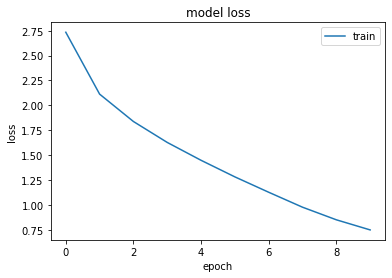

In [26]:
## plot accuracy
#plt.plot(history.history['accuracy']) # kx or similar Matlab commands for plotting
#plt.plot(history.history['val_accuracy'])
#plt.title('model accuracy')
#plt.ylabel('accuracy')
#plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='lower right')
#plt.show()

# plot history
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [33]:
## set for the final output
start_index = random.randint(0, len(text) - maxlen - 1)
sentence = text[start_index: start_index + maxlen]
randomizeOut = True
diversity = 0.5 # 0.5? depends on training length
maxChars = 400 # 400 is same as above

if randomizeOut:
    generated = ''
    sentence = text[start_index: start_index + maxlen]
    generated += sentence

seed = sentence.replace('\n','')
seed = seed.replace('\t','')
print('*** seed: <', seed ,'>')
#sys.stdout.write(generated)


for i in range(maxChars):
    x_pred = np.zeros((1, maxlen, len(chars)))
    for t, char in enumerate(sentence):
        x_pred[0, t, char_indices[char]] = 1.

    preds = model.predict(x_pred, verbose=0)[0]
    next_index = sample(preds, diversity)
    next_char = indices_char[next_index]

    sentence = sentence[1:] + next_char

    sys.stdout.write(next_char)
    sys.stdout.flush()
print()

*** seed: < ted christmas! the whole christmas seaso >
 to call.
oh, should it could sould dow.
for fear them in a bood for fishere in the hop,
sould sam-i-am

on a woll hall to poo stown the hat.
"i do not like them in a box.
and i cane to a call this liet as me coll.
her, house,
he ship, ploout to plooks our fith a finnt and slicks of some hame icccclicks.
bup i do not like them,
said the cat!
"not like this wand the can!
that is not in a hooks our 


In [34]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               86016     
_________________________________________________________________
dense_2 (Dense)              (None, 39)                5031      
Total params: 91,047
Trainable params: 91,047
Non-trainable params: 0
_________________________________________________________________
